# Aerial Drone-based Seal Detection

**INSERT 3 SEAL IMAGES HERE**

Author: Noor Wahle
- add a project summary

In [ ]:
# IMPORTS
import os
import glob
import cv2
import numpy as np
import pandas as pd
from PIL import Image
import seaborn as sns
from matplotlib import pyplot as plt
!pip install ultralytics
from ultralytics import YOLO
import torch
!pip install git+https://github.com/openai/CLIP.git
import open_clip as clip
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [2]:
device = 0 if torch.cuda.is_available() else 'cpu'
print("Using device:", device)

Using device: 0


## 1. Seal Detection

### Load WAID Dataset Images

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
import os
import yaml
from ultralytics import YOLO

# ==========================================
# 1. DEFINE THE "REAL" LOCATIONS
# ==========================================
# Based on your findings, this is where the actual images/labels live
REAL_DATASET_ROOT = "/content/WAID_Local/data/WAID"

# This is where your config file is currently sitting
SOURCE_YAML_PATH = "/content/WAID_Local/waid_seals.yaml"

print(f"Targeting Dataset Root: {REAL_DATASET_ROOT}")

# ==========================================
# 2. VERIFY DATA EXISTENCE
# ==========================================
# Let's make sure the images are actually there before we try to train
train_img_dir = os.path.join(REAL_DATASET_ROOT, "images", "train")
if not os.path.exists(train_img_dir):
    print(f"ERROR: Could not find training images at {train_img_dir}")
    print("Check if the folder name is 'train' or 'train_small'?")
    # simple fix if they are in 'train_small' but we want 'train'
    # usually WAID has both, we will check.
    available = os.listdir(os.path.join(REAL_DATASET_ROOT, "images"))
    print(f"Available folders in images: {available}")
    raise FileNotFoundError("Stopping to let you check directory names.")
else:
    num_imgs = len(os.listdir(train_img_dir))
    print(f"Success! Found {num_imgs} images in {train_img_dir}")


Targeting Dataset Root: /content/WAID_Local/data/WAID
Success! Found 10056 images in /content/WAID_Local/data/WAID/images/train


In [7]:
# ==========================================
# 3. FIX THE YAML
# ==========================================
# Read the file from the top level
with open(SOURCE_YAML_PATH, 'r') as f:
    config = yaml.safe_load(f)

# INJECT THE ABSOLUTE PATH
# This tells YOLO: "Ignore where this file is saved, the data is definitely HERE"
config['path'] = REAL_DATASET_ROOT

# Save this new, correct config INSIDE the data folder
corrected_yaml_path = os.path.join(REAL_DATASET_ROOT, "waid_seals_fixed.yaml")
with open(corrected_yaml_path, 'w') as f:
    yaml.dump(config, f, sort_keys=False)

print(f"Created corrected config: {corrected_yaml_path}")

Created corrected config: /content/WAID_Local/data/WAID/waid_seals_fixed.yaml


### Data Preprocessing

### Load and Train YOLOv8 Model

In [9]:
# ==========================================
# 4. TRAIN (Finally!)
# ==========================================
model = YOLO("yolov8n.pt") # Using YOLOv8n pre-trained model and fine-tune it on WAID seals

print("Starting training run...")
results = model.train(
    data=corrected_yaml_path,   # Use the fixed file
    imgsz=640,
    batch=16,
    epochs=1,
    device=0,
    project='runs/YOLOv8_seal_detection',
    name='seal_model_final',
    exist_ok=True,
    plots=True)

Starting training run...
Ultralytics 8.3.235 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/WAID_Local/data/WAID/waid_seals_fixed.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=1, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=seal_model_final, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=T

#### Evaluate on full Test Set

In [11]:
import numpy as np
from ultralytics import YOLO

# 1. Load model and run validation
model = YOLO('/content/runs/YOLOv8_seal_detection/seal_model_final/weights/best.pt')
metrics = model.val(data='/content/WAID_Local/data/WAID/waid_seals_fixed.yaml', split='test')

# 2. Extract Metrics Safely
# metrics.box.ap_class_index is a list of class IDs present in the test set.
# We need to find which "row" corresponds to Seals (Class ID 2).
target_id = 2

try:
    # Find the row index where class_id == 2
    seal_row_idx = metrics.box.ap_class_index.tolist().index(target_id)

    # Extract values using this row index
    seal_precision = metrics.box.p[seal_row_idx]
    seal_recall    = metrics.box.r[seal_row_idx]
    seal_f1        = metrics.box.f1[seal_row_idx]

    # AP@50 is the first column (index 0) of the all_ap matrix
    seal_map50     = metrics.box.all_ap[seal_row_idx, 0]

    # AP@50-95 is the average of all columns for that row (or use .maps[i])
    seal_map50_95  = metrics.box.maps[seal_row_idx]

    print("\n" + "="*40)
    print(f"🌊 SEAL DETECTION METRICS (Class {target_id}) 🌊")
    print("="*40)
    print(f"Precision: {seal_precision:.4f}")
    print(f"Recall:    {seal_recall:.4f}")
    print(f"F1-Score:  {seal_f1:.4f}")
    print(f"mAP@50:    {seal_map50:.4f}")
    print(f"mAP@50-95: {seal_map50_95:.4f}")
    print("="*40)

except ValueError:
    print(f"Error: Class ID {target_id} (Seal) was not found in the test results.")

Ultralytics 8.3.235 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,006,818 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1008.8±410.6 MB/s, size: 59.4 KB)
val: Scanning /content/WAID_Local/data/WAID/labels/test.cache... 1437 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 1437/1437 504.5Kit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 90/90 4.6it/s 19.4s
                   all       1437      23820      0.704      0.651      0.678      0.371
                 sheep        424      13323      0.859       0.84      0.895      0.477
                cattle        466       6240      0.773      0.855      0.876      0.502
                  seal        323       2689      0.789      0.865      0.894      0.553
               camelus         82        676      0.647      0.475      0.535      0.261
                 kiang         8

Confusion Matrix:


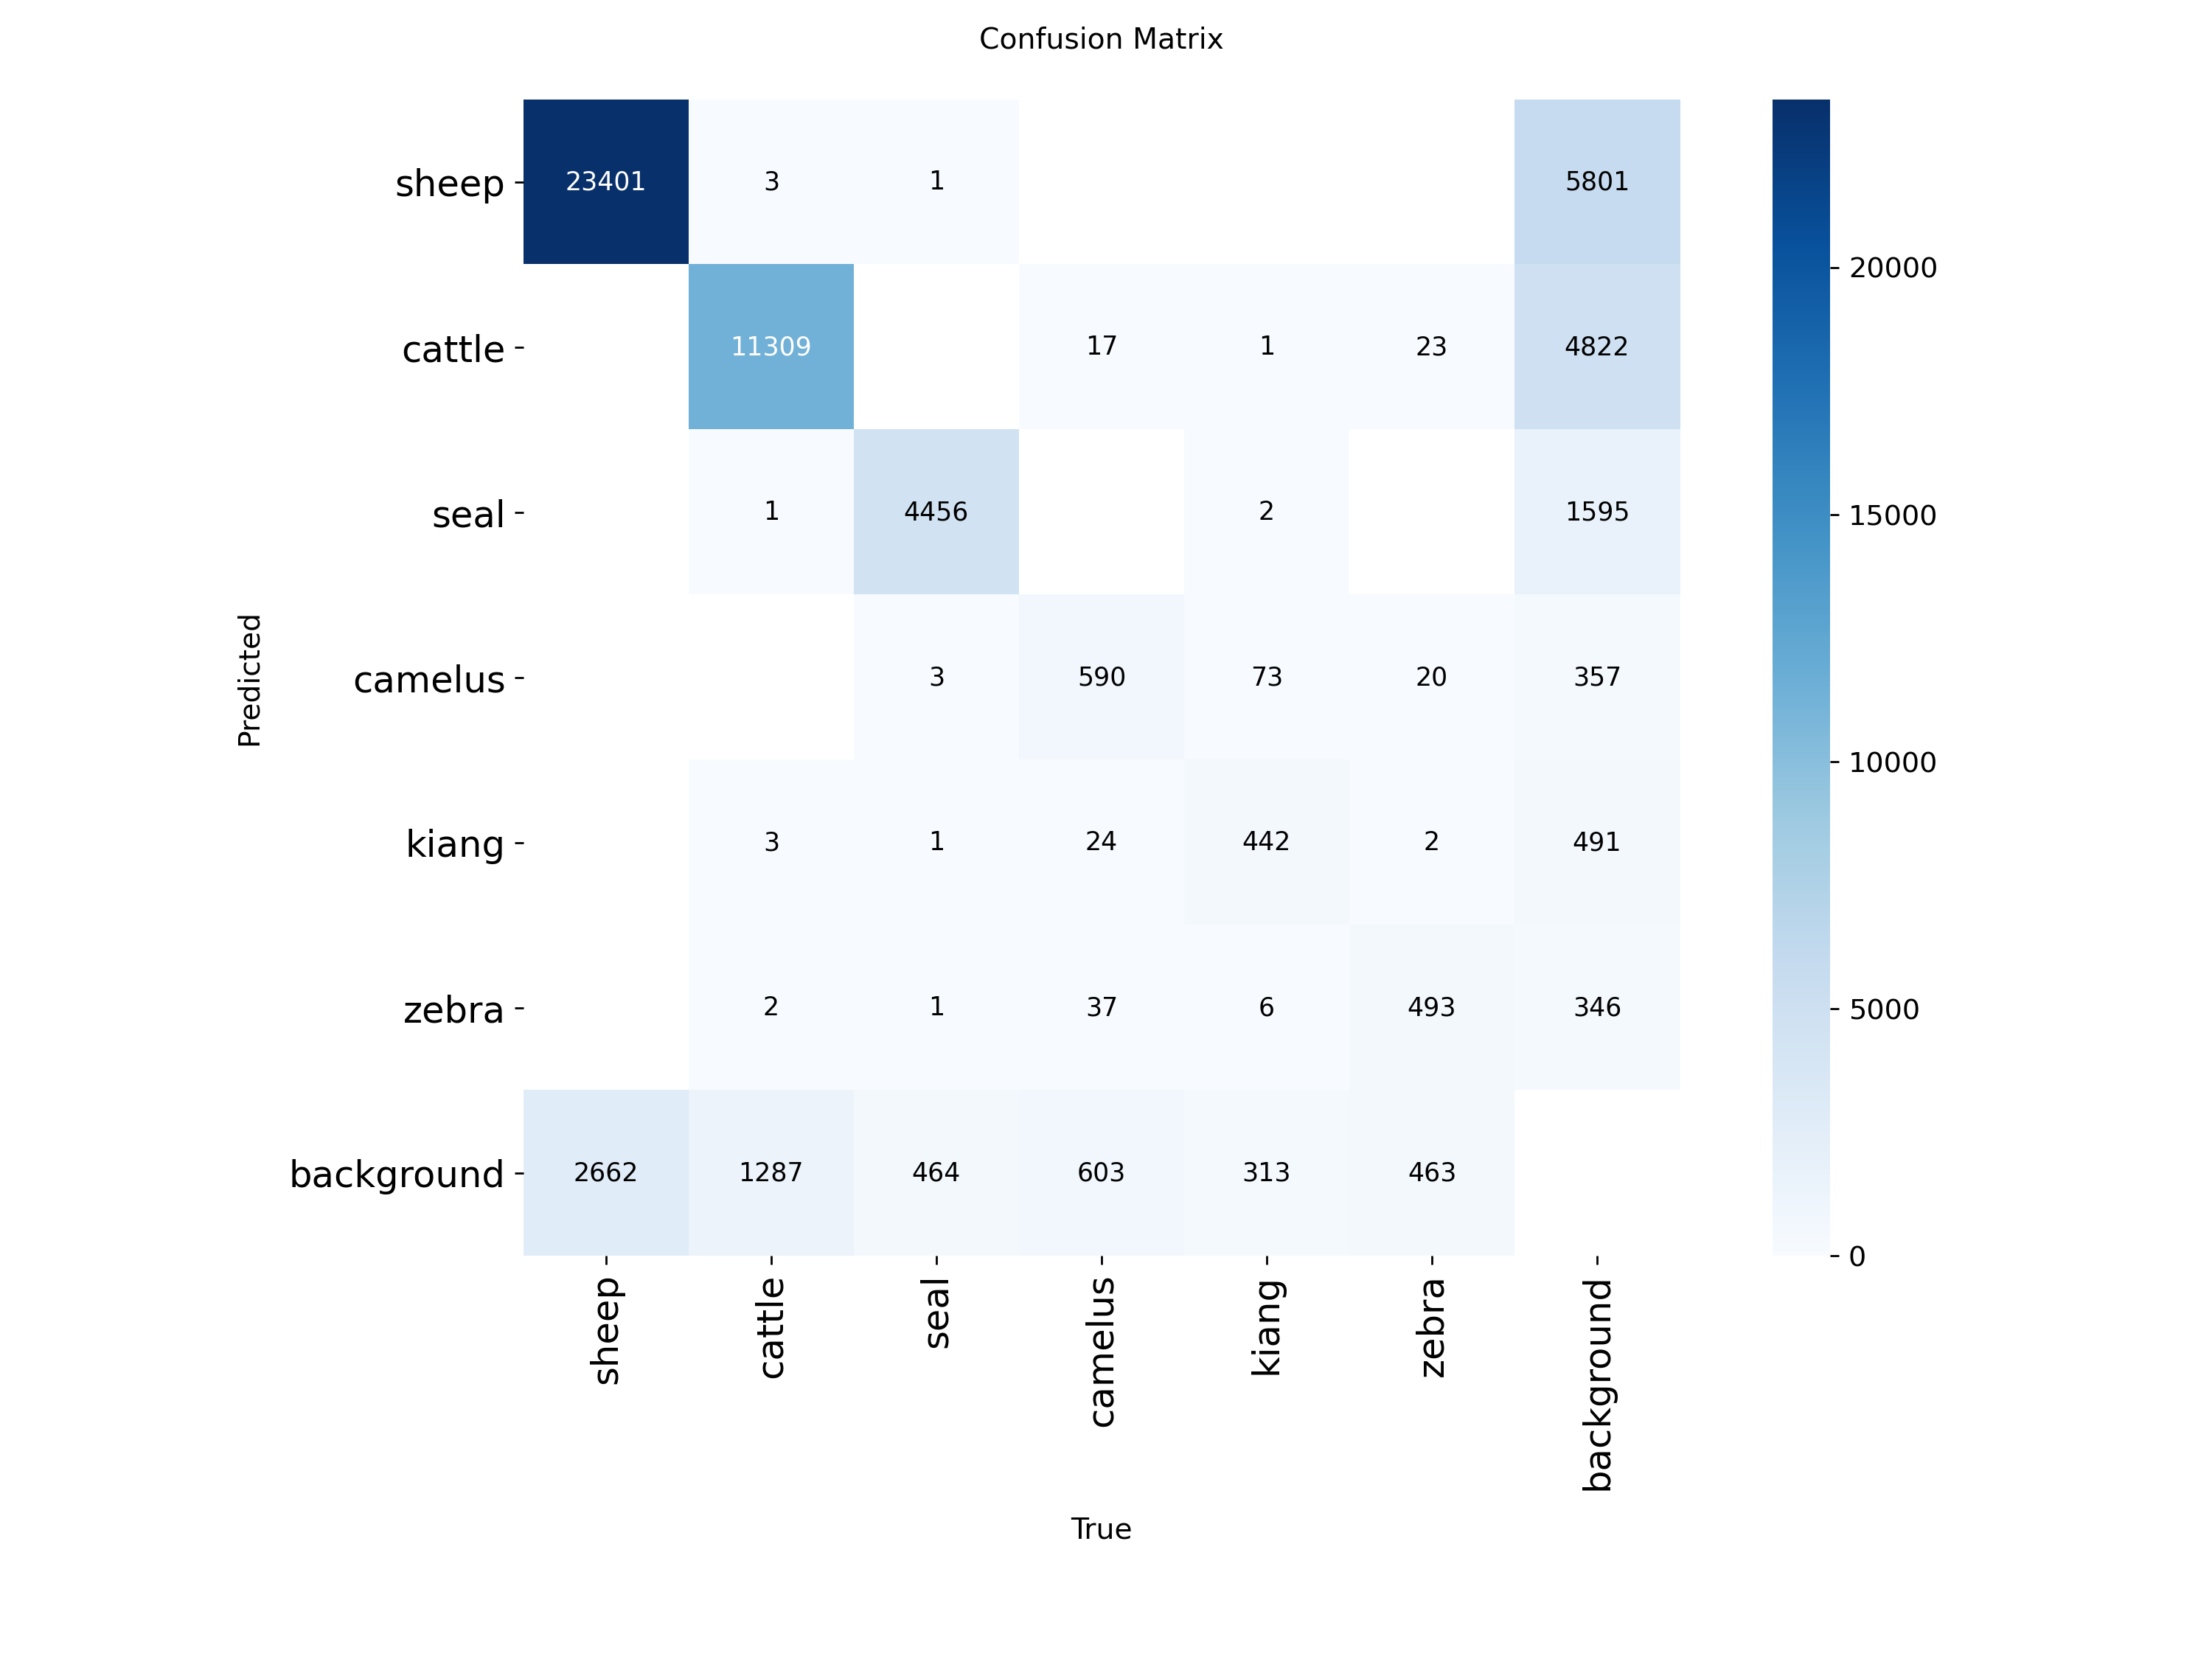

In [14]:
from IPython.display import Image, display

# 1. Display Confusion Matrix
# This file is generated automatically by the model.val() command above
cm_path = '/content/runs/YOLOv8_seal_detection/seal_model_final/confusion_matrix.png'
if os.path.exists(cm_path):
    print("Confusion Matrix:")
    display(Image(filename=cm_path, width=600))
else:
    print("Confusion matrix not found. (It might generate only after more epochs or check the 'val' folder)")

Found 323 test images containing seals.
Displaying 3 examples of SEAL detections...

0: 640x640 35 seals, 6.4ms
1: 640x640 9 seals, 6.4ms
2: 640x640 49 seals, 6.4ms
Speed: 6.1ms preprocess, 6.4ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


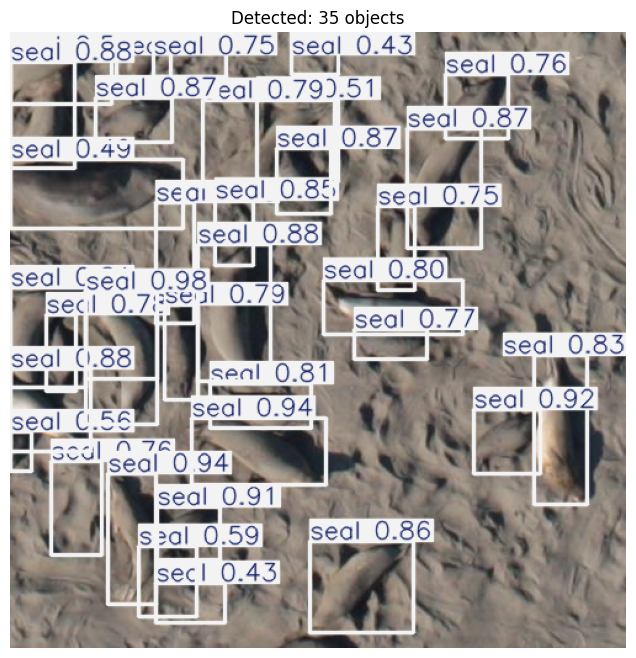

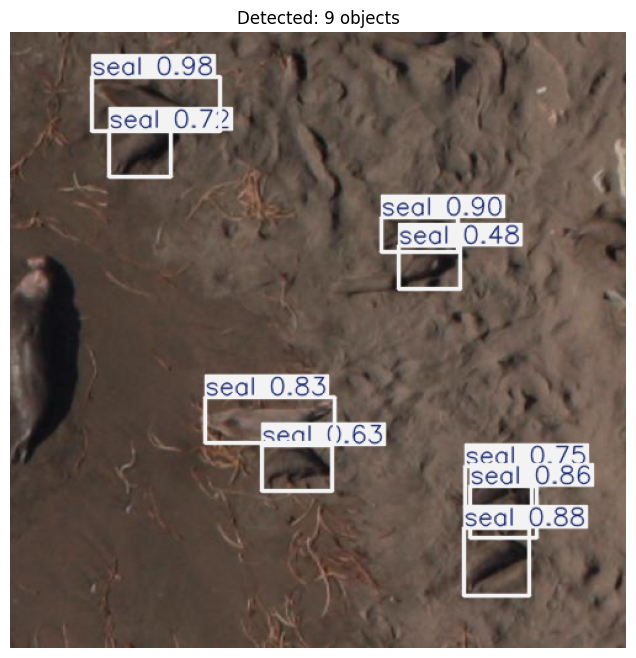

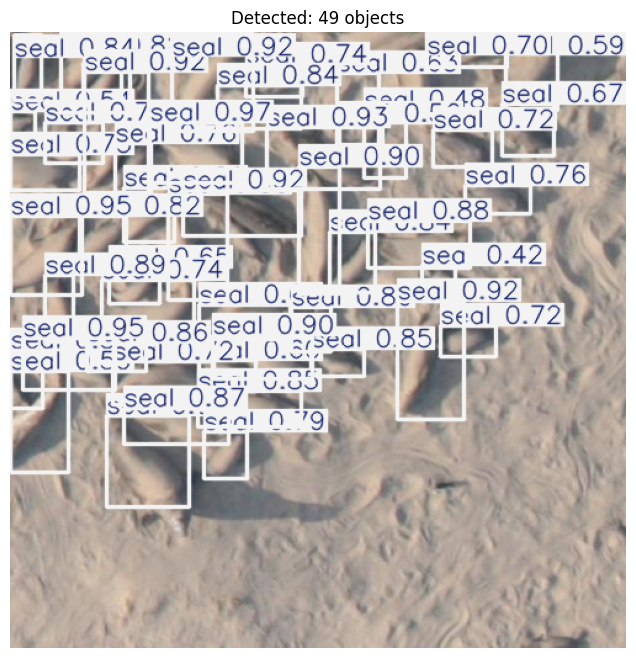

In [13]:
import random
import cv2
import matplotlib.pyplot as plt
import glob
import os

# 1. Find images that actually have seals (using the label files)
# We look for class_id '2' in the text files
label_dir = "/content/WAID_Local/data/WAID/labels/test"
image_dir = "/content/WAID_Local/data/WAID/images/test"

seal_image_paths = []
for label_file in glob.glob(os.path.join(label_dir, "*.txt")):
    with open(label_file, 'r') as f:
        if any(line.strip().startswith("2 ") for line in f):
            # Construct corresponding image path
            basename = os.path.basename(label_file).replace(".txt", ".jpg")
            img_path = os.path.join(image_dir, basename)
            if os.path.exists(img_path):
                seal_image_paths.append(img_path)

print(f"Found {len(seal_image_paths)} test images containing seals.")

# 2. Visualize 3 Confirmed Seal Images
print("Displaying 3 examples of SEAL detections...")
selected_images = random.sample(seal_image_paths, 3)

# Run inference
results = model.predict(selected_images, conf=0.4)

for result in results:
    img_array = result.plot()  # Draws boxes
    img_rgb = cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB)

    plt.figure(figsize=(10, 8))
    plt.imshow(img_rgb)
    plt.axis('off')
    plt.title(f"Detected: {len(result.boxes)} objects")
    plt.show()

## 2. Population Count per Image

In [ ]:
# Estimate the total seal count per image based on detection results.

## 3. Age Group Recognition

In [ ]:
# Apply CLIP embeddings to seal crops for unsupervised
# clustering of potential adult versus juvenile seals.

### Filter Dataset to Seal Bounding Boxes

### Cropping and Resizing

### Load CLIP model

### Extract CLIP Embeddings

In [ ]:
# pass each bounding box into CLIP
# get a clip embedding for each bounding box image

### K-Means Clustering of Adult vs Juvenile (k=2)

In [ ]:
# Group embeddings into two clusters (k=2), representing potential age groups

In [ ]:
# Optionally include normalized bounding box area as an additional feature

### Age Group Recognition Evaluation

In [ ]:
# clustering quality will be evaluated through
# visual inspection of cluster exemplars and unsupervised metrics like silhouette score and
# intra-cluster variance. A small subset of images may be manually labeled to serve as a
# sanity check.

In [ ]:
# Display grid samples from each cluster to assess visual consistency and interpret
# results